# Train 과정


In [1]:
import argparse
import datetime
import os
import traceback

import numpy as np
import torch
import yaml
from tensorboardX import SummaryWriter
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.autonotebook import tqdm

from backbone import EfficientDetBackbone
from efficientdet.dataset import BrainDataset, Resizer, Normalizer, Augmenter, collater
from efficientdet.loss import FocalLoss
from utils.sync_batchnorm import patch_replication_callback
from utils.utils import replace_w_sync_bn, CustomDataParallel, get_last_weights, init_weights, boolean_string
import json

data_path = '/home/kuchoco97/work/brain/data/'

with open(data_path + 'hem_frac_train_03.json', 'r') as file:
    ann = json.load(file)

In [ ]:
GPU_NUM = 2 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

In [2]:
class Params:
    def __init__(self, project_file):
        self.params = yaml.safe_load(open(project_file).read())

    def __getattr__(self, item):
        return self.params.get(item, None)

    
    
    
params = Params('projects/brain.yml')

ds = BrainDataset(ann, transform=Resizer())

train_ds, validation_ds  = torch.utils.data.random_split(ds, [6000, 1285], generator=torch.Generator().manual_seed(40))

training_generator = DataLoader(train_ds,
                          batch_size=32,
                          num_workers=4,
                          shuffle=True,
                          collate_fn = collater)

val_generator = DataLoader(validation_ds,
                               batch_size=32,
                               num_workers=4,
                               shuffle=True,
                               collate_fn = collater)

## EfficientDetBackbone 의 Return
> features, regression, classification, anchors

## ModelWithLoss 의 Return
> cls_loss, reg_loss



In [8]:
model = EfficientDetBackbone(num_classes= 2, compound_coef=0,
                                 ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))


class ModelWithLoss(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        self.criterion = FocalLoss()
        self.model = model
        self.debug = debug

    def forward(self, imgs, annotations, obj_list=None):
        _, regression, classification, anchors = self.model(imgs)
        if self.debug:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations,
                                                imgs=imgs, obj_list=obj_list)
        else:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations)
        return cls_loss, reg_loss


model = ModelWithLoss(model)

In [11]:
cls_loss, reg_loss = model(imgs, annot, obj_list=params.obj_list) # 1.model input으로부터 cls_loss, reg_loss 반환.

cls_loss = cls_loss.mean()
reg_loss = reg_loss.mean()

loss = cls_loss + reg_loss

loss.backward() #2.역전파

optimizer.step() #3. 가중치 업데이트

2

## ModelWithLoss
> FocaLoss()를 이용해 cls_loss와 reg_loss를 계산

In [ ]:
# loss.py
def calc_iou(a, b):
    # a(anchor) [boxes, (y1, x1, y2, x2)]
    # b(gt, coco-style) [boxes, (x1, y1, x2, y2)]

    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    iw = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 1])
    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)
    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih
    ua = torch.clamp(ua, min=1e-8)
    intersection = iw * ih
    IoU = intersection / ua

    return IoU


class FocalLoss(nn.Module):
    def __init__(self):
        super(FocalLoss, self).__init__()

    def forward(self, classifications, regressions, anchors, annotations, **kwargs):
        alpha = 0.25
        gamma = 2.0
        batch_size = classifications.shape[0]
        classification_losses = []
        regression_losses = []

        anchor = anchors[0, :, :]  # assuming all image sizes are the same, which it is
        dtype = anchors.dtype

        anchor_widths = anchor[:, 3] - anchor[:, 1]
        anchor_heights = anchor[:, 2] - anchor[:, 0]
        anchor_ctr_x = anchor[:, 1] + 0.5 * anchor_widths
        anchor_ctr_y = anchor[:, 0] + 0.5 * anchor_heights

        for j in range(batch_size):

            classification = classifications[j, :, :]
            regression = regressions[j, :, :]

            bbox_annotation = annotations[j]
            bbox_annotation = bbox_annotation[bbox_annotation[:, 4] != -1]

            classification = torch.clamp(classification, 1e-4, 1.0 - 1e-4)
            
            if bbox_annotation.shape[0] == 0:
                if torch.cuda.is_available():
                    
                    alpha_factor = torch.ones_like(classification) * alpha
                    alpha_factor = alpha_factor.cuda()
                    alpha_factor = 1. - alpha_factor
                    focal_weight = classification
                    focal_weight = alpha_factor * torch.pow(focal_weight, gamma)
                    
                    bce = -(torch.log(1.0 - classification))
                    
                    cls_loss = focal_weight * bce
                    
                    regression_losses.append(torch.tensor(0).to(dtype).cuda())
                    classification_losses.append(cls_loss.sum())
                else:
                    
                    alpha_factor = torch.ones_like(classification) * alpha
                    alpha_factor = 1. - alpha_factor
                    focal_weight = classification
                    focal_weight = alpha_factor * torch.pow(focal_weight, gamma)
                    
                    bce = -(torch.log(1.0 - classification))
                    
                    cls_loss = focal_weight * bce
                    
                    regression_losses.append(torch.tensor(0).to(dtype))
                    classification_losses.append(cls_loss.sum())

                continue
                
            IoU = calc_iou(anchor[:, :], bbox_annotation[:, :4])

            IoU_max, IoU_argmax = torch.max(IoU, dim=1)

            # compute the loss for classification
            targets = torch.ones_like(classification) * -1
            if torch.cuda.is_available():
                targets = targets.cuda()

            targets[torch.lt(IoU_max, 0.4), :] = 0

            positive_indices = torch.ge(IoU_max, 0.5)

            num_positive_anchors = positive_indices.sum()

            assigned_annotations = bbox_annotation[IoU_argmax, :]

            targets[positive_indices, :] = 0
            targets[positive_indices, assigned_annotations[positive_indices, 4].long()] = 1

            alpha_factor = torch.ones_like(targets) * alpha
            if torch.cuda.is_available():
                alpha_factor = alpha_factor.cuda()

            alpha_factor = torch.where(torch.eq(targets, 1.), alpha_factor, 1. - alpha_factor)
            focal_weight = torch.where(torch.eq(targets, 1.), 1. - classification, classification)
            focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

            bce = -(targets * torch.log(classification) + (1.0 - targets) * torch.log(1.0 - classification))

            cls_loss = focal_weight * bce

            zeros = torch.zeros_like(cls_loss)
            if torch.cuda.is_available():
                zeros = zeros.cuda()
            cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, zeros)

            classification_losses.append(cls_loss.sum() / torch.clamp(num_positive_anchors.to(dtype), min=1.0))

            if positive_indices.sum() > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
                anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

                gt_widths = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_ctr_x = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_ctr_y = assigned_annotations[:, 1] + 0.5 * gt_heights

                # efficientdet style
                gt_widths = torch.clamp(gt_widths, min=1)
                gt_heights = torch.clamp(gt_heights, min=1)

                targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
                targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
                targets_dw = torch.log(gt_widths / anchor_widths_pi)
                targets_dh = torch.log(gt_heights / anchor_heights_pi)

                targets = torch.stack((targets_dy, targets_dx, targets_dh, targets_dw))
                targets = targets.t()

                regression_diff = torch.abs(targets - regression[positive_indices, :])

                regression_loss = torch.where(
                    torch.le(regression_diff, 1.0 / 9.0),
                    0.5 * 9.0 * torch.pow(regression_diff, 2),
                    regression_diff - 0.5 / 9.0
                )
                regression_losses.append(regression_loss.mean())
            else:
                if torch.cuda.is_available():
                    regression_losses.append(torch.tensor(0).to(dtype).cuda())
                else:
                    regression_losses.append(torch.tensor(0).to(dtype))

        # debug
        imgs = kwargs.get('imgs', None)
        if imgs is not None:
            regressBoxes = BBoxTransform()
            clipBoxes = ClipBoxes()
            obj_list = kwargs.get('obj_list', None)
            out = postprocess(imgs.detach(),
                              torch.stack([anchors[0]] * imgs.shape[0], 0).detach(), regressions.detach(), classifications.detach(),
                              regressBoxes, clipBoxes,
                              0.5, 0.3)
            imgs = imgs.permute(0, 2, 3, 1).cpu().numpy()
            imgs = ((imgs * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255).astype(np.uint8)
            imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in imgs]
            display(out, imgs, obj_list, imshow=False, imwrite=True)

        return torch.stack(classification_losses).mean(dim=0, keepdim=True), \
               torch.stack(regression_losses).mean(dim=0, keepdim=True) * 50  # 

----------------
# How to Infer

In [ ]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone

In [ ]:
class ModelWithLoss(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        self.criterion = FocalLoss()
        self.model = model
        self.debug = debug

    def forward(self, imgs, annotations, obj_list=None):
        _, regression, classification, anchors = self.model(imgs)
        if self.debug:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations,
                                                imgs=imgs, obj_list=obj_list)
        else:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations)
        return cls_loss, reg_loss

In [17]:
eff_model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                             # replace this part with your project's anchor config
                             ratios=[(0.7, 1.4), (1.0, 1.0), (1.5, 0.7)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

eff_model.load_state_dict(torch.load('./logs/brain/efficientdet-d0_15_3000.pth'))
model = ModelWithLoss(eff_model)
eff_model.cuda()
eff_model.eval()
model.cuda()
model.eval()

ModelWithLoss(
  (criterion): FocalLoss()
  (model): EfficientDetBackbone(
    (bifpn): Sequential(
      (0): BiFPN(
        (conv6_up): SeparableConvBlock(
          (depthwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          )
          (pointwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
        (conv5_up): SeparableConvBlock(
          (depthwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          )
          (pointwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
  

In [45]:
x = validation_ds[3]['img']
x = x.to(torch.float32 if not use_float16 else torch.float16).permute(2, 0, 1).unsqueeze(dim=0)
y = validation_ds[3]['annot']
y = y.to(torch.float32 if not use_float16 else torch.float16).unsqueeze(dim=0).cuda()


with torch.no_grad():
    out1 = eff_model(x)
    out2 = model(x, y)

In [388]:
a = next(iter(val_generator))
x = a['img'].cuda()
y = a['annot'].cuda()

with torch.no_grad():
    out1 = eff_model(x)
    out2 = model(x, y)

In [392]:
_, regression, classification, anchors = out1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


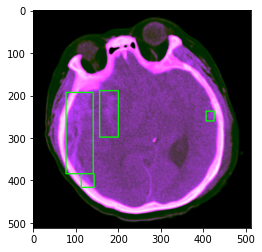

In [448]:
# ground truth

img = validation_ds[3]['img']
img = np.array(img)

for annot in validation_ds[3]['annot']:
    x_min, y_min, x_max, y_max, _ = np.array(annot, dtype=int)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
    
plt.imshow(img)
plt.show()

In [437]:
def preprocess(img, max_size=512, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    ori_imgs = [img]
    imgs_meta = [aspectaware_resize_padding(img, max_size, max_size,
                                            means=None) for img in ori_imgs]
    framed_imgs = [img_meta[0] for img_meta in imgs_meta]
    framed_metas = [img_meta[1:] for img_meta in imgs_meta]

    return ori_imgs, framed_imgs, framed_metas

In [438]:
a, b, c = preprocess(img)

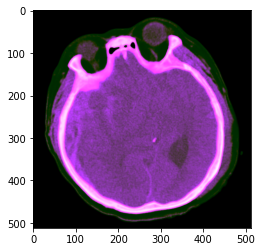

In [439]:
plt.imshow(b[0])

In [442]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import invert_affine, postprocess, aspectaware_resize_padding

compound_coef = 0
force_input_size = None  # set None to use default size

threshold = 0.1
iou_threshold = 0.1

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = [ 'hemorrhage', 'fracture' ]

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

eff_model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                             # replace this part with your project's anchor config
                             ratios=[(0.7, 1.4), (1.0, 1.0), (1.5, 0.7)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

eff_model.load_state_dict(torch.load('./logs/brain/efficientdet-d0_15_3000.pth'))
eff_model.requires_grad_(False)
eff_model.eval()

if use_cuda:
    eff_model = eff_model.cuda()
if use_float16:
    eff_model = eff_model.half()

with torch.no_grad():
    features, regression, classification, anchors = eff_model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])


tensor([[[ -18.4000,   -7.2000,   26.4000,   15.2000],
         [ -12.0000,  -12.0000,   20.0000,   20.0000],
         [  -7.2000,  -20.0000,   15.2000,   28.0000],
         ...,
         [-120.9245,  163.5377, 1016.9246,  732.4623],
         [  41.6253,   41.6253,  854.3747,  854.3747],
         [ 163.5377, -161.5620,  732.4623, 1057.5620]]], device='cuda:2')